---
title: 'Spatial KDE plots in Python'
date: '2025-04-28'
categories:
  - GIS
jupyter:
  kernelspec:
    display_name: Python (data-science)
    language: python
    name: data-science
---

I frequently use KDE plots for my work, but I have not previously used them for spatial analysis. I found a really cool example [here](https://residentmario.github.io/geoplot/gallery/plot_nyc_collision_factors.html) using the *geoplot* Python library. *geoplot* uses *Seaborn* behind the scenes to generate the KDE plots.

Unfortunately, `geoplot` didn't work for me and I set about finding my own solution. In this post, I explain how I acheived that.

# Data: fatal crashes in Brisbane

I will work with the vehicle crashes dataset from Queensland roads, which is available from [the Queensland open data portal](https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads). This dataset provides information on location and characteristics of crashes in Queensland for all reported road traffic crashes that occurred from 1 January 2001 to 30 November 2023.

I only want to focus on fatal crashes, so the only three columns of interest are *Crash_Longitude*, *Crash_Latitutde*, and *Count_Casualty_Fatality*. And of course only those with a fatality (*Count_Casualty_Fatality > 0*).

In [16]:
import pandas as pd

fatal_crashes = pd.read_csv(
    '../data/qld-road-crash-locations.csv',
    usecols=['Crash_Longitude', 'Crash_Latitude', 'Count_Casualty_Fatality'],
)
fatal_crashes = fatal_crashes[fatal_crashes['Count_Casualty_Fatality'] > 0]

The above data is still for all of QLD, so the next step is to get Brisbane's council boundaries and retain only those crashes that happened within the council boundaries. I will use a *GeoParquet* file for this (shared on GitHub [here](https://github.com/sandeepdhakal/notebooks/blob/main/data/brisbane-suburbs.parq)).

In [17]:
import geopandas as gpd

# dissolve because we only need the outer boundaries
brisbane = gpd.read_parquet('../data/brisbane-suburbs.parq').dissolve()

# convert to a geodataframe
fatal_crashes = gpd.GeoDataFrame(
    fatal_crashes,
    geometry=gpd.points_from_xy(fatal_crashes['Crash_Longitude'], fatal_crashes['Crash_Latitude']),
    crs=brisbane.crs
).drop(columns=['Crash_Longitude', 'Crash_Latitude']).clip(brisbane)

In [18]:
fatal_crashes.head()

,Count_Casualty_Fatality,geometry
362708,1,POINT (153.00744 -27.6564)
388774,1,POINT (153.00476 -27.65595)
120572,1,POINT (153.00375 -27.6558)
210495,1,POINT (152.99434 -27.65306)
267168,1,POINT (152.96758 -27.63583)


# First attempt with geoplot
When I used the `geoplot` example ([here](https://residentmario.github.io/geoplot/gallery/plot_nyc_collision_factors.html)), I got an error
```'MultiPolygon' object is not iterable```, which is most likely caused by API changes to either *Seaborn*, *Matplotlib* because *geoplot* was last updated 2 years ago. Perhaps its also related to [this open issue](https://github.com/ResidentMario/geoplot/issues/288).

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

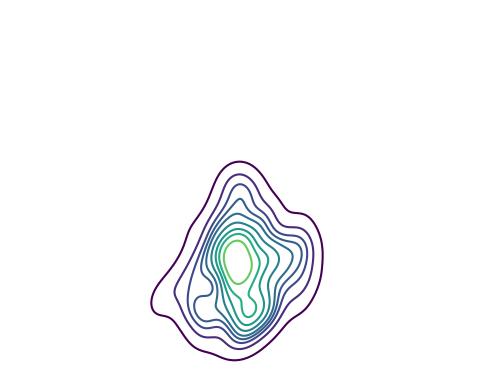

In [19]:
import geoplot as gplt
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots()

gplt.kdeplot(
    fatal_crashes,
    cmap='viridis',
    thresh=0.05,
    clip=brisbane.geometry,
    ax=ax
)
gplt.polyplot(brisbane, zorder=1, ax=ax)

# Initial KDE plot
So, I set about finding my own solution, and that's when I came across [this post ](https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b/) by Håvard Wallin Aagesen that shows how to use *Seaborn*'s kdeplot for geospatial analysis. I have used that as an inspiration to generate a plot similar to that in the *geoplot* example.

The first step is drawing the KDE plot using *Seaborn*. We can see in the plot below that seaborn has drawn 10 contours by default.

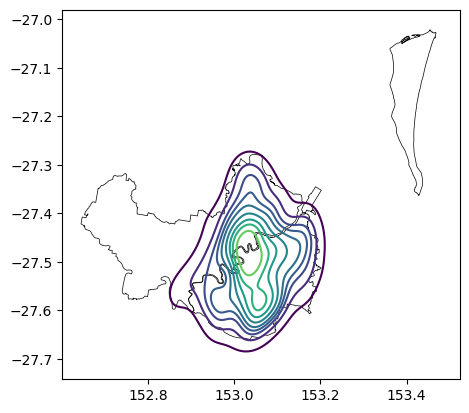

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
brisbane.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
sns.kdeplot(fatal_crashes, x=fatal_crashes.geometry.x, y=fatal_crashes.geometry.y, weights='Count_Casualty_Fatality', cmap='viridis', ax=ax)
ax.set(xlabel='', ylabel='')
plt.show()

We can see that some of the contours extend beyond the city's boundaries, but in the reference example from geoplot, the contours are within the city limit, and that's what I want to achieve.

The solution is to individually access these contours, convert them into Polygons (or MultiPolygons), and then trim them using the city boundaries. *Credit goes to [this Medium article](https://medium.com/data-science/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b) for the initial idea.* Some of the example code in that article didn't work for me (*perhaps due to upstream changes with seaborn?*).

# Improved KDE plot clipped to boundaries
## Getting individual contour regions

*Seaborn*'s `kdeplot` returns a collection of children, including a `QuadContourSet` instance that contains information about the contour and contour regions.

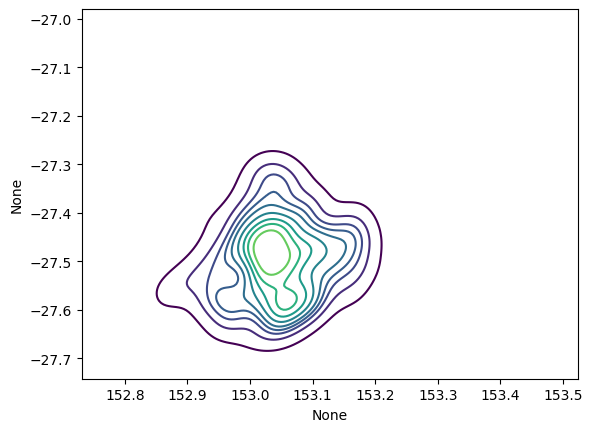

In [21]:
kde = sns.kdeplot(fatal_crashes, x=fatal_crashes.geometry.x, y=fatal_crashes.geometry.y, weights='Count_Casualty_Fatality', cmap='viridis')

In [22]:
import pprint

pprint.pp(kde.get_children())

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),


## Clipping contour regions to boundaries

And each `QuadCountourSet` instance is a collection of contour paths, which we can access with the `get_paths` method. We can generate a shapely *Polygon* using the `to_polygons` method.

In [23]:
# credit to https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b/

from shapely import Polygon
from matplotlib.contour import QuadContourSet

contour_set = None
for i in kde.get_children():
    if type(i) is QuadContourSet:
        contour_set = i
        break

contour_paths = []
# Loop through all contours
for contour in contour_set.get_paths(): 
    # Create a polygon for the countour
    # First polygon is the main countour, the rest are holes
    for ncp,cp in enumerate(contour.to_polygons()):
        x = cp[:,0]
        y = cp[:,1]
        new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
        if ncp == 0:
            poly = new_shape
        else:
            # Remove holes, if any
            poly = poly.difference(new_shape)

    # Append polygon to list
    contour_paths.append(poly)

# make holes corresponding to the inner contours
contour_polys = [contour_paths[i].difference(contour_paths[i+1]) for i in range(len(contour_paths)-2)] + [contour_paths[-1]]

df = pd.DataFrame(zip(contour_set.levels, contour_polys), columns=['level', 'geometry'])
gdf = gpd.GeoDataFrame(df, crs=brisbane.crs)

clipped_kde_gdf = gdf.clip(brisbane)

Now, if we plot `clipped_kde_gdf`, we can see that the contour has been nicely clipped to Brisbane's boundaries. 

<Axes: >

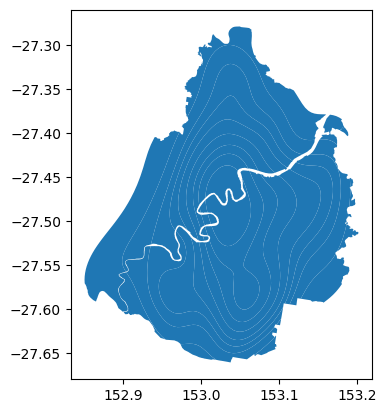

In [24]:
clipped_kde_gdf.plot()

## Final plot

Finally, we can plot the complete plot, this time with some background tiles.

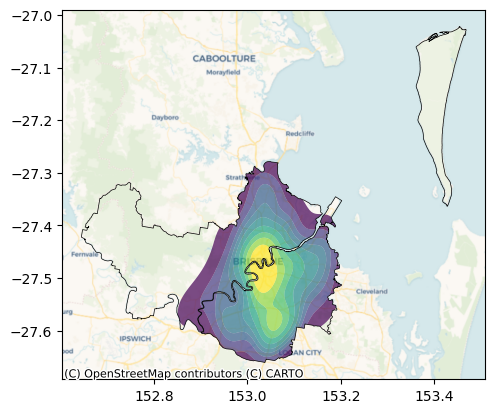

In [25]:
#| classes: preview-image

import contextily as cx

fig, ax = plt.subplots()
brisbane.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
cx.add_basemap(ax, crs=brisbane.crs, source=cx.providers.CartoDB.Voyager)
clipped_kde_gdf.plot('level', ax=ax, cmap='viridis', alpha=0.7)
ax.set(xlabel='', ylabel='')
plt.show()